In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import healpy as hp
from src.build_yx1.make_field_plots_v2 import plot_healpix_equalarea_from_frame
import zarr
import hdbscan

In [2]:
root = "/media/nick/cluster/projects/data/killi_tracker/"
project_name = "20250716"
projection_path = Path(root) / "output_data" / "sphere_projections" / project_name
well_ind = 2

# load nuccleus df
nucleus_df_path = projection_path / f"well{well_ind:04}_nucleus_df.csv"
nucleus_df = pd.read_csv(nucleus_df_path)
nucleus_df = nucleus_df.rename(columns={"t":"t_phys"})

# load sphere df
sphere_df_path = projection_path / f"well{well_ind:04}_sphere_fits.csv"
sphere_df = pd.read_csv(sphere_df_path)


# join
nucleus_df = nucleus_df.merge(sphere_df.loc[:, ["t", "center_z_smooth", "center_y_smooth", "center_x_smooth"]], how="left", left_on="t_int", right_on="t")
nucleus_df = nucleus_df.drop(columns=["t"]).rename(columns={"center_z_smooth":"zs", "center_y_smooth":"ys", "center_x_smooth":"xs", "t_int":"t"})#
# nucleus_df.head()

nucleus_df.head()

,x,y,z,r,theta,phi,area,intensity,t,t_phys,well,zs,ys,xs
0,679.077623,407.935363,24.187500,703.355220,2.934657,4.084356,56.631688,129.937500,0,0.0,2,712.536692,524.872941,763.986747
1,769.742770,626.902795,54.405405,666.018027,2.987547,1.514441,785.764668,139.355856,0,0.0,2,712.536692,524.872941,763.986747
2,693.939712,557.336768,57.447514,659.622860,3.024281,2.707604,1281.291936,134.654696,0,0.0,2,712.536692,524.872941,763.986747
3,768.903092,620.200261,54.818182,664.608988,2.997470,1.519269,1012.291419,138.965035,0,0.0,2,712.536692,524.872941,763.986747
4,689.530225,553.006614,58.409091,658.952347,3.020508,2.780322,467.211424,134.659091,0,0.0,2,712.536692,524.872941,763.986747


### Experiment with simple density-based clustering

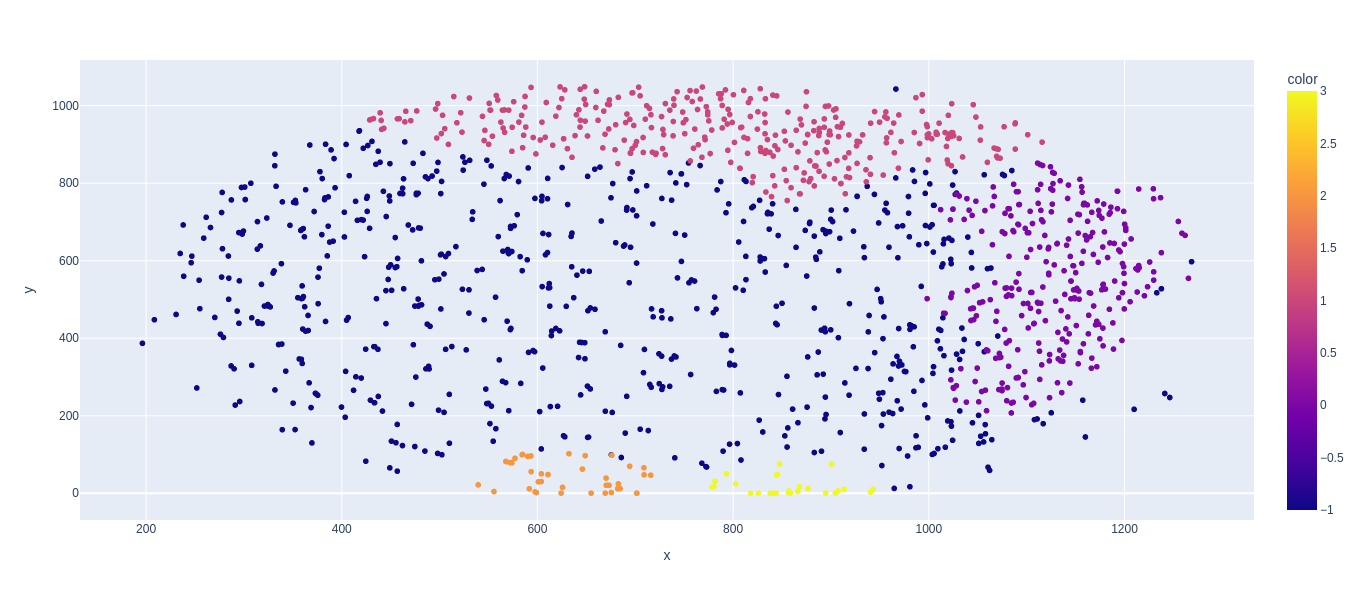

In [3]:
import numpy as np
from sklearn.cluster import DBSCAN

# pull data for timepoint
t_ind = 15
t_filter = nucleus_df["t"]==t_ind
t_df = nucleus_df.loc[t_filter]

# do clustering
coords_rad = t_df[["theta", "phi"]].to_numpy()
# coords_rad = np.radians(coords_deg)

# angular neighborhood of, say, 8 degrees:
eps_deg = 6
eps_rad = np.deg2rad(eps_deg)

db = DBSCAN(eps=eps_rad, min_samples=25, metric='haversine').fit(coords_rad)
labels = db.labels_ 

fig = px.scatter(t_df, x="x", y="y", color=labels)
fig.update_layout(
    autosize=False,  # Set to False to manually control size
    width=800,       # Set the width in pixels
    height=600       # Set the height in pixels
)
fig.show()

In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.cluster import OPTICS, cluster_optics_dbscan

# pull data for a single timepoint
t_ind = 14
t_df = nucleus_df.loc[nucleus_df["t"] == t_ind].copy()

# convert angles to radians for haversine distance
U = t_df[["theta", "phi"]].to_numpy()
U_rad = np.radians(U)

# ------------------------------------------------------------
# OPTICS clustering on the sphere (haversine metric)
# ------------------------------------------------------------
# max_eps sets the largest neighborhood considered.
# Smaller => restricts to finer density scales.
# xi controls how sharp a valley in reachability must be
# to define a separate cluster (larger => fewer clusters).

optics_model = OPTICS(
    min_samples=25,
    max_eps=np.deg2rad(20),   # maximum angular neighborhood
    metric="haversine",
    xi=0.1,                  # steepness threshold for cluster detection
    min_cluster_size=30,
    cluster_method="xi",
    n_jobs=-1,
)

optics_model.fit(U_rad)

# Extract DBSCAN-like labels at an angular epsilon of ~0.5°
eps_rad = np.deg2rad(0.5)
labels = cluster_optics_dbscan(
    reachability=optics_model.reachability_,
    core_distances=optics_model.core_distances_,
    ordering=optics_model.ordering_,
    eps=eps_rad,
)

# ------------------------------------------------------------
# Plot results
# ------------------------------------------------------------
t_df["label"] = labels
fig = px.scatter(
    t_df, x="x", y="y", color="label",
    color_continuous_scale="Viridis",
    title=f"OPTICS clusters (t={t_ind})"
)
fig.update_layout(width=800, height=600)
fig.show()


### Use NN stats to estimate each cell's local density

In [5]:
from src.symmetry_breaking.cluster_tracking import find_clusters_per_timepoint, track_clusters_over_time, stitch_tracklets
from tqdm import tqdm 

t_ind = 32
t_df = nucleus_df.loc[nucleus_df["t"] == t_ind].copy().reset_index()
t_sphere = sphere_df.loc[sphere_df["t"] == t_ind].copy().reset_index()

# 1) clusters per frame
clusters_by_t = find_clusters_per_timepoint(
    t_df, 
    t_sphere,
    d_thresh=25, 
    min_size=25,  # tune
    fluo_col="intensity",
    sphere_radius_col="radius",
    time_col="t",
    sphere_center_cols=( "center_z_smooth", "center_y_smooth", "center_x_smooth")
)



t_df["labels"] = 0
cdict = clusters_by_t[t_ind]
for lb in range(len(cdict)):
    li = cdict[lb]["member_index"]
    t_df.loc[li, "labels"] = lb + 1


fig = px.scatter(
    t_df, x="x", y="y", color="labels",
    color_continuous_scale="Viridis",
    title=f"OPTICS clusters (t={t_ind})"
)
fig.update_layout(width=800, height=600)
fig.show()

In [6]:
# 1) clusters per frame
clusters_by_t = find_clusters_per_timepoint(
    nucleus_df, 
    sphere_df,
    d_thresh=25.0, 
    min_size=25,  # tune
    fluo_col="intensity",
    time_col="t",
    sphere_radius_col="radius",
    sphere_center_cols=( "center_z_smooth", "center_y_smooth", "center_x_smooth")
)

# 2) link across time (motion/feature-aware, with merges)
cluster_ts, merges_df = track_clusters_over_time(
    clusters_by_t,
    link_metric="overlap",         # or "jaccard"
    sim_min=0.3,
    max_centroid_angle=np.deg2rad(15),
    w_sim=1.0, w_feat=0.7, w_pred=0.7,  # tune
    pred_step=1.0
)

# # 3) stitch fragmented tracklets (bridge small gaps, fix flips)
# stitched_ts, stitch_log = stitch_tracklets(
#     cluster_ts,
#     gap_max=2, window=1,
#     link_metric="overlap", sim_min=0.3,
#     max_centroid_angle=np.deg2rad(15),
#     w_sim=1.0, w_feat=0.7, w_pred=0.7, w_size=3.0,
#     max_iters=3
# )

In [9]:
t_ind = 32
t_df = nucleus_df.loc[nucleus_df["t"] == t_ind].copy().reset_index()
t_sphere = sphere_df.loc[sphere_df["t"] == t_ind].copy().reset_index()
t_track = cluster_ts[

t_df["labels"] = 0
cdict = clusters_by_t[t_ind]
for lb in range(len(cdict)):
    li = cdict[lb]["member_index"]
    t_df.loc[li, "labels"] = lb + 1


fig = px.scatter(
    t_df, x="x", y="y", color="labels",
    color_continuous_scale="Viridis",
    title=f"OPTICS clusters (t={t_ind})"
)
fig.update_layout(width=800, height=600)
fig.show()

,t,cluster_id_local,size,theta_mean,theta_max,area_cap,fluo_mean,deg_mean,nn_dist_mean,member_index,...,merged_from,start_t,end_t,duration,mean_size,max_size,mean_fluo,mean_deg,mean_nn_dist,n_obs
49,30,1,48,0.071305,0.129726,22634.641051,121.452538,5.458333,16.317096,"[44813, 44886, 44906, 44911, 44952, 45887, 459...",...,[],30,30,1,48.0,48,121.452538,5.458333,16.317096,1
50,31,0,1929,0.259394,0.596027,458302.205594,135.041537,16.540176,16.926070,"[46229, 46230, 46231, 46232, 46233, 46234, 462...",...,[],31,31,1,1929.0,1929,135.041537,16.540176,16.926070,1
51,31,1,32,0.076059,0.141419,26534.148346,132.839039,4.250000,18.125751,"[47223, 47260, 47264, 47276, 47279, 47283, 473...",...,[],31,31,1,32.0,32,132.839039,4.250000,18.125751,1
52,32,0,2051,0.268500,0.620020,500778.210675,134.422755,16.199902,16.933021,"[48751, 48752, 48753, 48754, 48755, 48756, 487...",...,[],32,32,1,2051.0,2051,134.422755,16.199902,16.933021,1
53,32,1,51,0.084483,0.191860,49365.827755,118.930441,7.686275,15.618167,"[49833, 49893, 49912, 49920, 49930, 49931, 499...",...,[],32,32,1,51.0,51,118.930441,7.686275,15.618167,1


In [7]:
cluster_ts["duration"].max()

19